# Análise de preços de casas (índia)

imagem_casa.jpg

---

O presente projeto tem como finalidade realizar uma análise aprofundada de uma base de dados referente aos preços de imóveis, visando o desenvolvimento de um modelo preditivo capaz de estimar valores futuros com base em variáveis explicativas relevantes.

- DICIONÁRIO

| **Coluna**          | **Descrição**                                                 |
| ------------------- | ------------------------------------------------------------- |
| **Index**             | Identificador único da linha no dataset.                      |
| **Title**             | Título do anúncio do imóvel.                                  |
| **Description**       | Descrição detalhada do imóvel.                                |
| **Amount(in rupees)** | Valor total do imóvel em rúpias.                              |
| **Price (in rupees)** | Preço por unidade de área (ex: por sqft) em rúpias.           |
| **location**          | Localização do imóvel (ex: cidade ou bairro).                 |
| **Carpet Area**       | Área útil interna do imóvel.                                  |
| **Status**            | Estado do imóvel (ex: pronto para morar, em construção).      |
| **Floor**             | Andar onde o imóvel está localizado.                          |
| **Transaction**       | Tipo de transação (ex: revenda, nova).                        |
| **Furnishing**        | Nível de mobília (ex: mobiliado, semi, não mobiliado).        |
| **facing**            | Direção para a qual o imóvel está voltado (ex: leste, oeste). |
| **overlooking**       | Vista ou orientação do imóvel (ex: parque, rua).              |
| **Society**           | Nome do condomínio ou empreendimento.                         |
| **Bathroom**          | Quantidade de banheiros.                                      |
| **Balcony**           | Quantidade de varandas.                                       |
| **Car Parking**       | Tipo e quantidade de vagas de estacionamento.                 |
| **Ownership**         | Tipo de posse do imóvel (ex: freehold, co-operative).         |
| **Super Area**        | Área total construída do imóvel.                              |
| **Dimensions**        | Dimensões do imóvel (largura x comprimento).                  |
| **Plot Area**         | Área total do terreno do imóvel.                              |


- FUNÇÕES

In [1]:
# ===================== FUNÇÃO TRATAR MOEDA INDIANA =====================

def converter_india_to_num(texto):
    try:
        texto = str(texto).strip().lower()
        if 'lac' in texto:
            num = float(texto.replace('lac','').strip())
            return int(num * 100_000)
        elif 'cr' in texto:
            num = float(texto.replace('cr','').strip())
            return int(num * 10_000_000)
        else:
            return int(float(texto))
    except:
        return None



# ===================== FUNÇÃO TRATAR ANDARES =====================


def extrair_andar(valor):
    if pd.isna(valor):
        return pd.Series([np.nan, np.nan])

    valor = str(valor).lower().strip()

    nums = re.findall(r'\d+', valor)

    if 'ground' in valor:
        floor = 0
    elif 'basement' in valor:
        floor = -1
    else:
        floor = int(nums[0]) if nums else np.nan

    match = re.search(r'out of (\d+)', valor)
    if match:
        max_floors = int(match.group(1))
    elif nums:
        max_floors = int(nums[-1])
    else:
        max_floors = np.nan

    return pd.Series([floor, max_floors])




# ===================== FUNÇÃO PARA SUAVIZAR OUTLIERS =====================
def tratar_outliers(df_train, df_validation, col, max_limite=None):
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    if max_limite:
        limite_superior = min(limite_superior, max_limite)

    # Train
    df_train_filtrado = df_train[(df_train[col] >= limite_inferior) & (df_train[col] <= limite_superior)]

    # Validation
    df_validation_filtrado = df_validation[(df_validation[col] >= limite_inferior) & (df_validation[col] <= limite_superior)]

    return df_train_filtrado, df_validation_filtrado




# ===================== FUNÇÃO PARA TREINAR, TESTAR E AVALIAR MODELO =====================

def train_test_avaliate(model, x_train, x_test, y_train, y_test):
  model.fit(x_train, y_train)
  pred = model.predict(x_test)

  mae = mean_absolute_error(y_test, pred)
  rmse = root_mean_squared_error(y_test, pred)
  r2 = r2_score(y_test, pred)

  print(f'MAE: {mae:.2f}')
  print(f'RMSE: {rmse:.2f}')
  print(f'R2: {r2:.2f}')

  return model




  # ===================== FUNÇÃO PARA TESTAR E AVALIAR MODELO EM VALIDAÇÃO =====================

def test_avaliate(model, x_val, y_val):
  pred = model.predict(x_val)

  mae = mean_absolute_error(y_val, pred)
  rmse = root_mean_squared_error(y_val, pred)
  r2 = r2_score(y_val, pred)

  print(f'MAE: {mae:.2f}')
  print(f'RMSE: {rmse:.2f}')
  print(f'R2: {r2:.2f}')

- IMPORTS

In [49]:
# Manipulação de dados
import pandas as pd
import numpy as np
import re

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# pré-processamento/modelos/métricas
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# Outros
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Download modelo
import joblib

- PALETA DE CORES UTILIZADA

In [3]:
colors = ['#B2C83B', '#74BD66', '#3B9F7A', '#2E8B7E', '#327A81', '#396B82', '#435A82', '#4A477C', '#492C68']
sns.set_palette(sns.color_palette(colors))
sns.color_palette(colors)

[(0.6980392156862745, 0.7843137254901961, 0.23137254901960785),
 (0.4549019607843137, 0.7411764705882353, 0.4),
 (0.23137254901960785, 0.6235294117647059, 0.47843137254901963),
 (0.1803921568627451, 0.5450980392156862, 0.49411764705882355),
 (0.19607843137254902, 0.47843137254901963, 0.5058823529411764),
 (0.2235294117647059, 0.4196078431372549, 0.5098039215686274),
 (0.2627450980392157, 0.35294117647058826, 0.5098039215686274),
 (0.2901960784313726, 0.2784313725490196, 0.48627450980392156),
 (0.28627450980392155, 0.17254901960784313, 0.40784313725490196)]

- ANÁLISE EXPLORATÓRIA

In [4]:
# Lendo dataframe
pd.set_option('display.max_columns', None)

df = pd.read_csv('house_prices.csv')
display(df.head())
print('\n')
df.info()

,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,Furnishing,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,Unfurnished,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN
2,2,2 BHK Ready to Occupy Flat for sale in Sunrise...,Up for immediate sale is a 2 BHK apartment in ...,1.40 Cr,17500.0,thane,779 sqft,Ready to Move,10 out of 29,Resale,Unfurnished,East,Garden/Park,Sunrise by Kalpataru,2,NaN,1 Covered,Freehold,NaN,NaN,NaN
3,3,1 BHK Ready to Occupy Flat for sale Kasheli,This beautiful 1 BHK Flat is available for sal...,25 Lac,NaN,thane,530 sqft,Ready to Move,1 out of 3,Resale,Unfurnished,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN
4,4,2 BHK Ready to Occupy Flat for sale in TenX Ha...,"This lovely 2 BHK Flat in Pokhran Road, Thane ...",1.60 Cr,18824.0,thane,635 sqft,Ready to Move,20 out of 42,Resale,Unfurnished,West,"Garden/Park, Main Road",TenX Habitat Raymond Realty,2,NaN,1 Covered,Co-operative Society,NaN,NaN,NaN




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187148 entries, 0 to 187147
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              187148 non-null  int64  
 1   Title              187147 non-null  object 
 2   Description        184125 non-null  object 
 3   Amount(in rupees)  187147 non-null  object 
 4   Price (in rupees)  169504 non-null  float64
 5   location           187147 non-null  object 
 6   Carpet Area        106569 non-null  object 
 7   Status             186532 non-null  object 
 8   Floor              180075 non-null  object 
 9   Transaction        187064 non-null  object 
 10  Furnishing         184253 non-null  object 
 11  facing             116975 non-null  object 
 12  overlooking        105772 non-null  object 
 13  Society            77613 non-null   object 
 14  Bathroom           186322 non-null  object 
 15  Balcony            138239 non-null  object 
 16  

Analisando rapidamente os dados, observei que as colunas `Dimensions` e `Plot Area`, estão com 100% dos valores nulos, o que impossibilita seu tratamento, logo, será necessário removê-las do conjunto de dados. Além disso, notei que algumas colunas que deveriam conter valores numéricos, como `Amount` e `Carpet Area`, apresentam strings misturadas aos números. Para realizar a conversão correta desses campos, será preciso efetuar um tratamento adequado dos dados antes da transformação.

In [5]:
# Dropnado colunas que não ajudarão
df.drop(columns=['Index', 'Title', 'Description', 'Society', 'Dimensions', 'Plot Area', 'Status'], inplace=True)

**Por que dropei cada coluna?**

- **Index:** É o índice das colunas, não ajudará em nada o modelo.
- **Title, Description e Society:** Além de serem muito diversificados, dificultando a tokenização, também não influenciam no preço.
- **Dimensions e Plot Area:** Os dados estão 100% nulos, não ajudará no modelo, provavelmente só o confundirá.
- **Status:** Todas as colunas só possuem um único valor, **Ready to Move**.


**Obs.:** Antes de iniciar o tratamento dos dados, irei dividir o conjunto em treino e validação logo no início, a fim de evitar data leakage (vazamento de dados).

In [6]:
# Dividindo os dados de treino e validação
df_train, df_validation = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
print('Tamanho do df_train', df_train.shape)
print('Tamanho do df_validation', df_validation.shape)

Tamanho do df_train (149718, 14)
Tamanho do df_validation (37430, 14)


Agora que os dados foram dividos, posso seguir com o tratamento de forma mais segura.

In [8]:
# Função para tratar 'amount'
# Train
df_train['Amount(in rupees)'] = df_train['Amount(in rupees)'].apply(converter_india_to_num)

# Validation
df_validation['Amount(in rupees)'] = df_validation['Amount(in rupees)'].apply(converter_india_to_num)

In [9]:
# Tratando 'Carpet Area' e 'Super Area'
# Train
df_train['Carpet Area'] = df_train['Carpet Area'].str.extract(r'(\d+)').astype('float64')
df_train['Super Area'] = df_train['Super Area'].str.extract(r'(\d+)').astype('float64')

# Validation
df_validation['Carpet Area'] = df_validation['Carpet Area'].str.extract(r'(\d+)').astype('float64')
df_validation['Super Area'] = df_validation['Super Area'].str.extract(r'(\d+)').astype('float64')

In [10]:
# Analisando 'andares'
df_train.Floor.value_counts(dropna=False)

,count
Floor,
2 out of 4,9952
1 out of 4,9557
3 out of 4,7026
1 out of 3,5695
NaN,5643
...,...
Upper Basement out of 20,1
9 out of 42,1
38 out of 41,1


In [11]:
# Função para tratar andares
# Train
df_train[['Floor', 'max_floors']] = df_train['Floor'].apply(extrair_andar)

# Validation
df_validation[['Floor', 'max_floors']] = df_validation['Floor'].apply(extrair_andar)

In [12]:
# Tratando 'Car Parking'
# Train
df_train['Car Parking Type'] = df_train['Car Parking'].str.extract(r'\d+\s*(.*)')
df_train['Car Parking'] = df_train['Car Parking'].str.extract(r'(\d+)').astype('float64')

# Validation
df_validation['Car Parking Type'] = df_validation['Car Parking'].str.extract(r'\d+\s*(.*)')
df_validation['Car Parking'] = df_validation['Car Parking'].str.extract(r'(\d+)').astype('float64')

In [13]:
df_train['Car Parking Type'].value_counts()

,count
Car Parking Type,
Covered,41017
"Covered,",16822
Open,9223


In [14]:
# Tirando a virgula
# Train
df_train['Car Parking Type'] = df_train['Car Parking Type'].str.replace(',', '')

# Validation
df_validation['Car Parking Type'] = df_validation['Car Parking Type'].str.replace(',', '')

In [15]:
# Tratando 'Balcony' > 10
# Train
df_train['Balcony'] = df_train['Balcony'].apply(lambda x: 11 if x == '> 10' else x).astype('float64')

# Validation
df_validation['Balcony'] = df_validation['Balcony'].apply(lambda x: 11 if x == '> 10' else x).astype('float64')

In [16]:
# Tratando 'Balcony' > 10
# Train
df_train['Bathroom'] = df_train['Bathroom'].apply(lambda x: 11 if x == '> 10' else x).astype('float64')

# Validation
df_validation['Bathroom'] = df_validation['Bathroom'].apply(lambda x: 11 if x == '> 10' else x).astype('float64')

Agora que tratei e formatei os dados, posso analisar os numeros nulos e trata-los também.

In [17]:
# Verificando nulos
df_train.isna().sum()

,0
Amount(in rupees),7788
Price (in rupees),14176
location,1
Carpet Area,64403
Floor,5643
Transaction,70
Furnishing,2320
facing,56155
overlooking,65168
Bathroom,661


In [18]:
# Preenchendo com a mediana
cols = ['Amount(in rupees)', 'Price (in rupees)']

# Loop para preencher nulos usando o modo do train
for col in cols:
    # Train
    df_train[col] = df_train[col].fillna(df_train[col].median())

    # Validation
    df_validation[col] = df_validation[col].fillna(df_train[col].median())


In [19]:
# Preenchendo com a moda
cols = ['Bathroom', 'Furnishing', 'Floor', 'max_floors']

# Loop para preencher nulos usando o modo do train
for col in cols:
    # Train
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

    # Validation
    df_validation[col] = df_validation[col].fillna(df_train[col].mode()[0])


In [20]:
# Preenchendo com 'Not Informed'
cols = ['facing', 'overlooking', 'Car Parking Type', 'Ownership', 'Transaction']

# Train
df_train[cols] = df_train[cols].fillna('Not Informed')

# Validation
df_validation[cols] = df_validation[cols].fillna('Not Informed')

In [21]:
# Preenhcendo com 0
cols = ['Balcony', 'Car Parking']

# Train
df_train[cols] = df_train[cols].fillna(0)

# Validation
df_validation[cols] = df_validation[cols].fillna(0)

In [22]:
# Preenchendo pela mediana agrupada por 'location' (para não distorcer a veracidade dos valores)
cols = ['Carpet Area', 'Super Area']
df_train[cols] = df_train.groupby('location')[cols].transform(lambda x: x.fillna(x.median()))

# Calcula as medianas no train
medianas = df_train.groupby('location')[cols].median()

# Preenche no validation
for col in cols:
    df_validation[col] = df_validation['location'].map(medianas[col]).combine_first(df_validation[col])

Depois que tratei todos os dados nulos, irei verificar como ficou a distribuição dos dados e verificar outliers.

In [23]:
df_train.describe().round()

,Amount(in rupees),Price (in rupees),Carpet Area,Floor,Bathroom,Balcony,Car Parking,Super Area,max_floors
count,1.497180e+05,149718.0,149717.0,149718.0,149718.0,149718.0,149718.0,149717.0,149718.0
mean,1.174409e+07,7405.0,1122.0,4.0,2.0,1.0,2.0,1177.0,9.0
std,3.992090e+07,23365.0,1715.0,5.0,1.0,1.0,22.0,535.0,8.0
min,1.000000e+05,0.0,1.0,-1.0,1.0,0.0,0.0,1.0,1.0
25%,5.000000e+06,4520.0,780.0,2.0,2.0,0.0,0.0,900.0,4.0
50%,7.800000e+06,6034.0,1000.0,3.0,2.0,1.0,0.0,1230.0,5.0
75%,1.360000e+07,8481.0,1300.0,5.0,3.0,2.0,1.0,1416.0,11.0
max,1.400300e+10,6700000.0,495970.0,75.0,11.0,11.0,999.0,9450.0,150.0


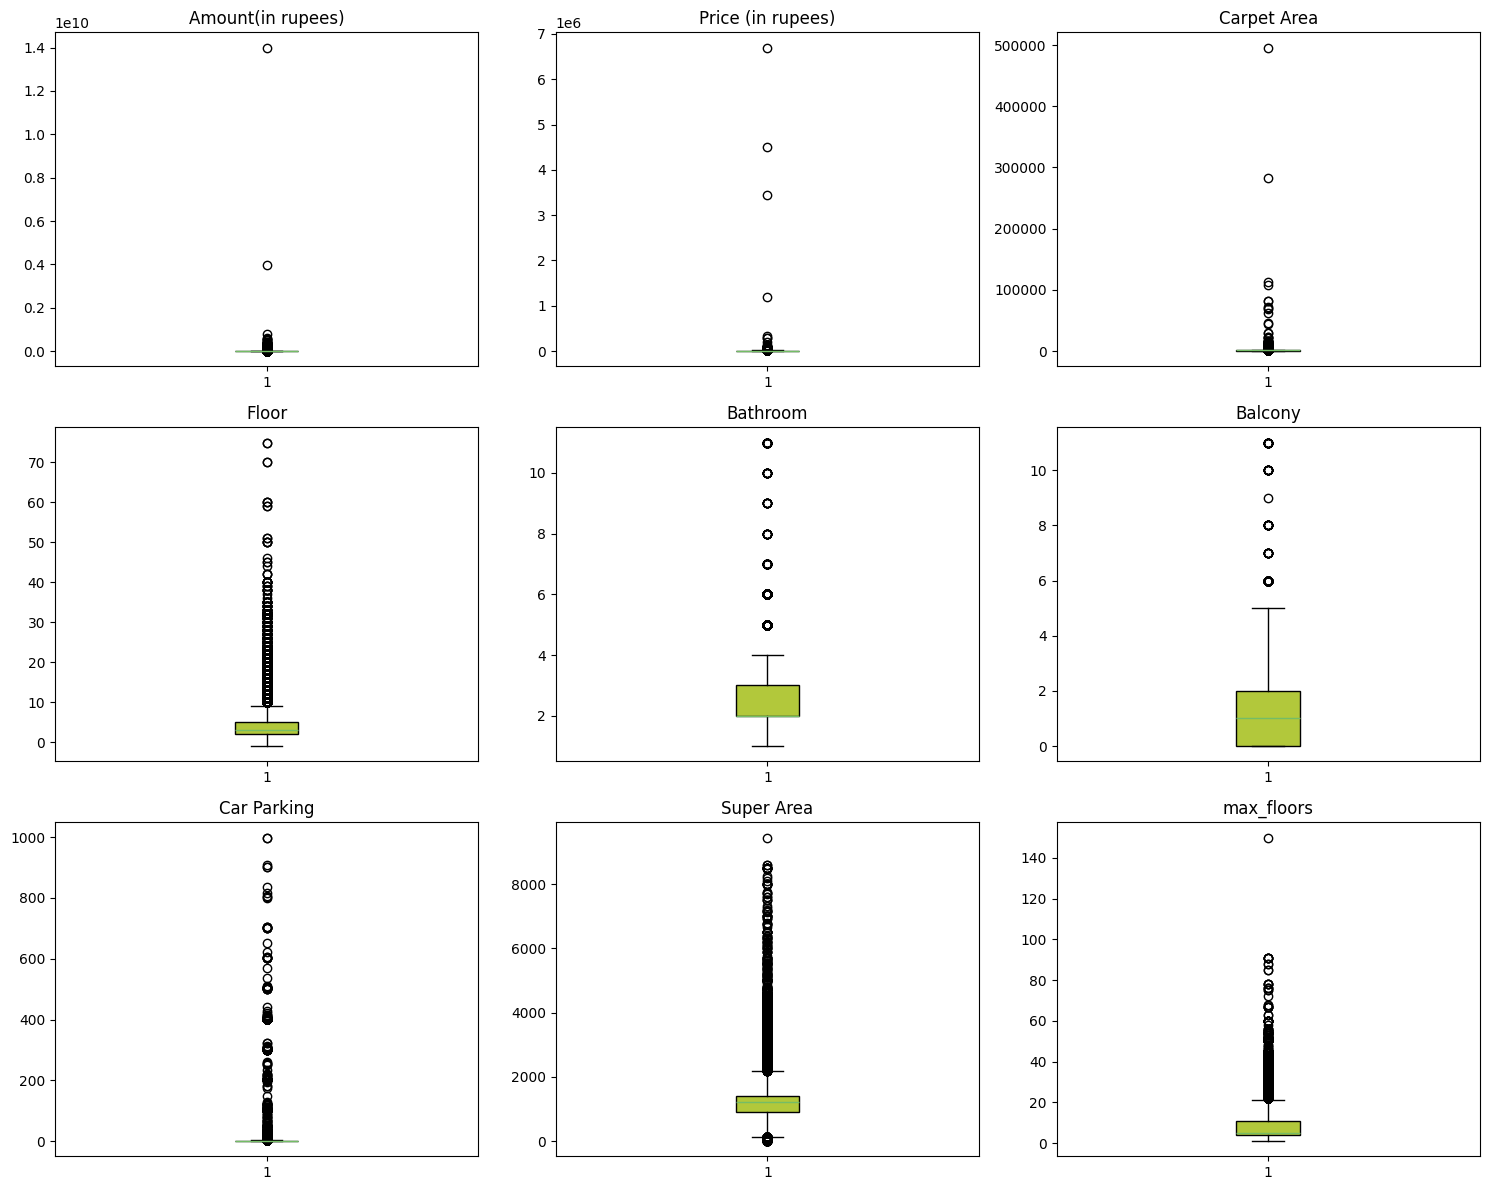

In [24]:
# Boxplots plots
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(15, n_rows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.boxplot(df_train[col].dropna(), patch_artist=True)
    plt.title(col)
    plt.tight_layout()

plt.show()


In [25]:
cols = {
    'Amount(in rupees)': 15_000_000_0,
    'Carpet Area': 10_000,
    'Super Area': 12_000,
    'Floor': 100,
    'Car Parking': 20
}

# Itera pela lista e aplica a função em ambos os dataframes
for coluna, limite in cols.items():
    df_train, df_validation = tratar_outliers(
        df_train,
        df_validation,
        coluna,
        max_limite=limite
    )

print(f"Formato df_train após remoção de outliers: {df_train.shape}")
print(f"Formato df_validation após remoção de outliers: {df_validation.shape}")

Formato df_train após remoção de outliers: (111327, 16)
Formato df_validation após remoção de outliers: (29844, 16)


Como os dados numéricos tinham muitos ouliers, resolvi aplicar uma técnica para suavizar esses valores extremos, fazendo assim, com que o modelo tenha uma melhor aprendizagem sobre os dados.

/tmp/ipython-input-65000957.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlacoes.values, y=correlacoes.index, palette='viridis')


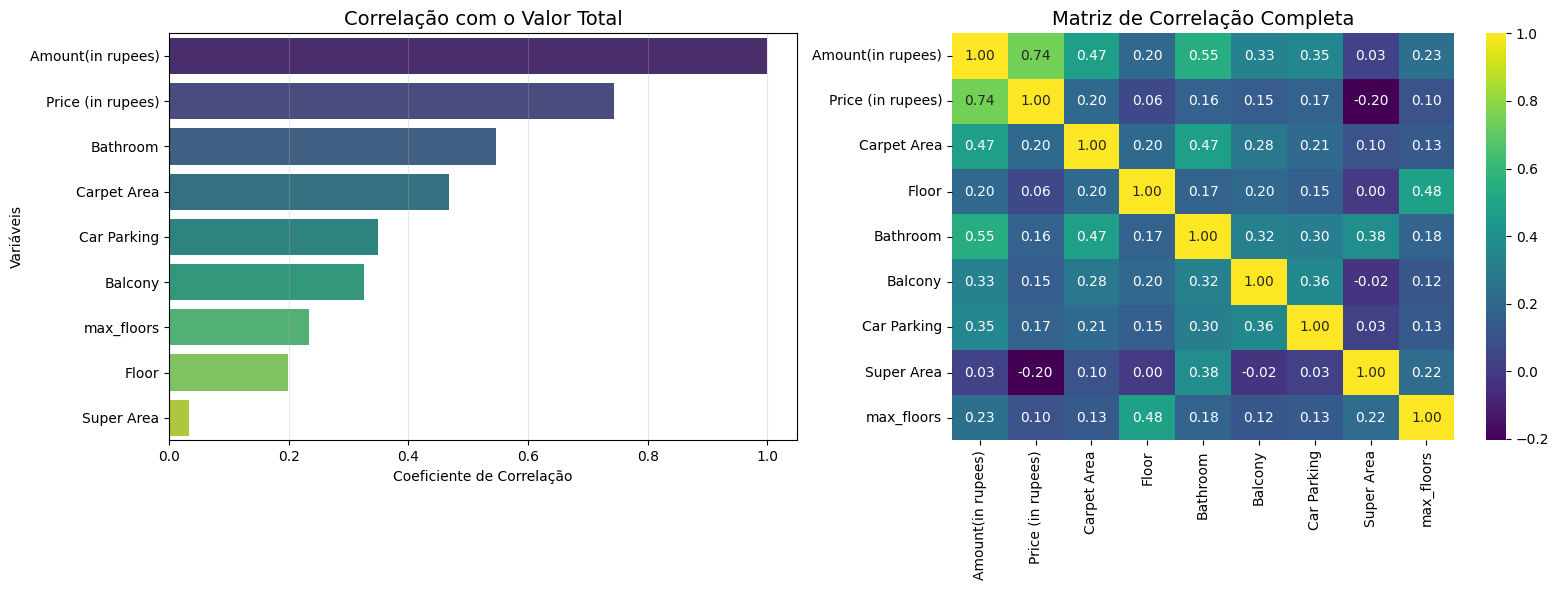

In [26]:
numeric_cols = df_train.select_dtypes(include=['int64', 'float64'])
correlacoes = numeric_cols.corr()['Amount(in rupees)'].sort_values(ascending=False)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=correlacoes.values, y=correlacoes.index, palette='viridis')
plt.title('Correlação com o Valor Total', fontsize=14)
plt.xlabel('Coeficiente de Correlação')
plt.ylabel('Variáveis')
plt.grid(axis='x', alpha=0.3)

plt.subplot(1, 2, 2)
sns.heatmap(numeric_cols.corr(), cmap='viridis', annot=True, fmt='.2f')
plt.title('Matriz de Correlação Completa', fontsize=14)

plt.tight_layout()
plt.show()


Analisando as correlações, consegui verificar que não há correlacões muito fortes, porém, existe correlação.

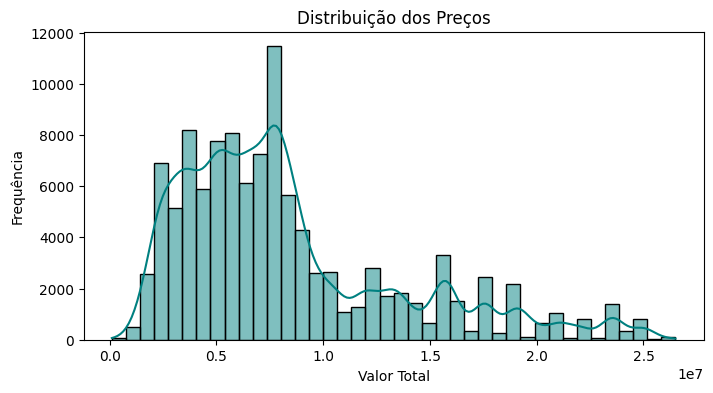

In [27]:
# Distribuição de Amount
plt.figure(figsize=(8,4))
sns.histplot(df_train['Amount(in rupees)'], bins=40, kde=True, color='teal')
plt.title('Distribuição dos Preços')
plt.xlabel('Valor Total')
plt.ylabel('Frequência')
plt.show()

Os valores são bem variádos, porém é possível ver que a maioria das propriedades esstão em torno de 6000 rúpias.

/tmp/ipython-input-876310716.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_preco.values, y=media_preco.index, palette='viridis')


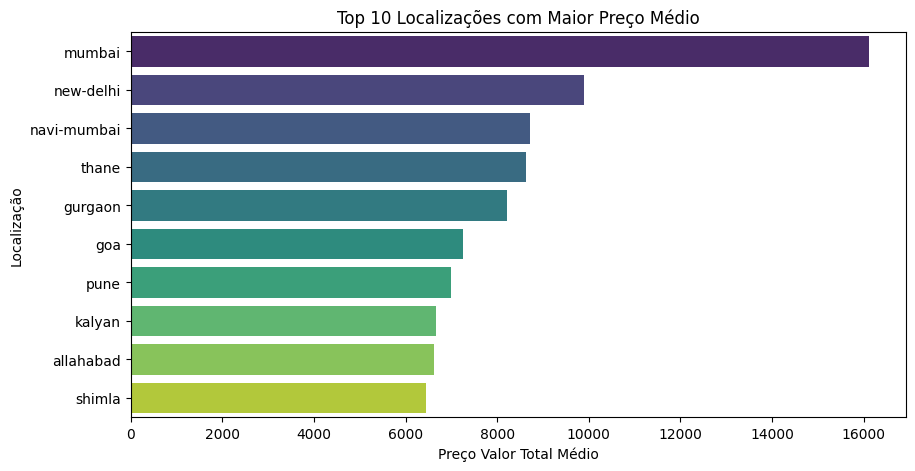

In [28]:
# Preço por localização
plt.figure(figsize=(10,5))
media_preco = df_train.groupby('location')['Price (in rupees)'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=media_preco.values, y=media_preco.index, palette='viridis')
plt.title('Top 10 Localizações com Maior Preço Médio')
plt.xlabel('Preço Valor Total Médio')
plt.ylabel('Localização')
plt.show()


/tmp/ipython-input-4258338958.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, y='location', order=df_train['location'].value_counts().index[:10], palette='viridis')


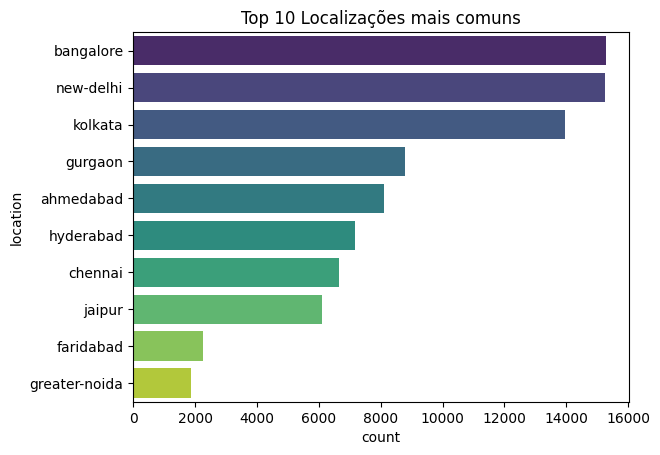

In [29]:
sns.countplot(data=df_train, y='location', order=df_train['location'].value_counts().index[:10], palette='viridis')
plt.title('Top 10 Localizações mais comuns')
plt.show()

Analisando os gráficos sobre localização, é interessante ver que **bangalore** é o lugar onde os preços são menores, porém é onde é mais popular, ou seja, onde há mais vendas. Já **new-delhi** é a segunda mais popular e a primeira mais cara.

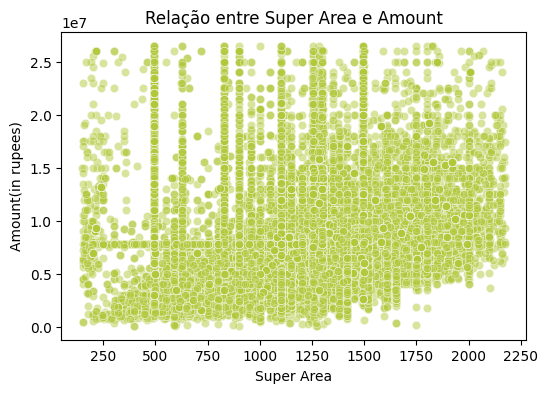

In [30]:
# Correlação entre Area e Amount
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_train, x='Super Area', y='Amount(in rupees)', alpha=0.5)
plt.title('Relação entre Super Area e Amount')
plt.xlabel('Super Area')
plt.ylabel('Amount(in rupees)')
plt.show()


O gráficos de correlação entre área e preço, mostra que não há uma linearidade muito forte entre elas, afirmande o que foi mostrado no gráfico "Correlação com preço" quanto no gráfico "Matriz de correlação completa".

/tmp/ipython-input-2693955900.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x='Furnishing', y='Amount(in rupees)', estimator='mean', palette='magma', errorbar=None)


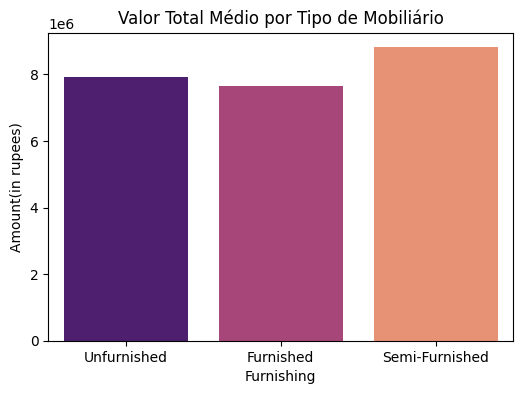

In [31]:
# Valor Total por tipo mobiliario
plt.figure(figsize=(6,4))
sns.barplot(data=df_train, x='Furnishing', y='Amount(in rupees)', estimator='mean', palette='magma', errorbar=None)
plt.title('Valor Total Médio por Tipo de Mobiliário')
plt.show()


Já no valor total médio por tipo mobiliário, vemos que não há uma disparidade tão grande. São todas bem distribuidas. Porém, os valores são maiores geralmente são maiores nas propriedades semi-mobiliadas.

Olhando mais afundo sobre os dados, e verificando de forma mais visual, posso seguir agora com a transformação dos dados categoricos para numéricos, para assim, poder prosseguir com o modelo preditivo.

In [32]:
# Salvando dados tratados
df_train.to_csv('df_train.csv', index=False)
df_validation.to_csv('df_validation.csv', index=False)

- PRÉ-PROCESSAMENTO

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111327 entries, 112884 to 121958
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Amount(in rupees)  111327 non-null  float64
 1   Price (in rupees)  111327 non-null  float64
 2   location           111327 non-null  object 
 3   Carpet Area        111327 non-null  float64
 4   Floor              111327 non-null  float64
 5   Transaction        111327 non-null  object 
 6   Furnishing         111327 non-null  object 
 7   facing             111327 non-null  object 
 8   overlooking        111327 non-null  object 
 9   Bathroom           111327 non-null  float64
 10  Balcony            111327 non-null  float64
 11  Car Parking        111327 non-null  float64
 12  Ownership          111327 non-null  object 
 13  Super Area         111327 non-null  float64
 14  max_floors         111327 non-null  float64
 15  Car Parking Type   111327 non-null  object 
dtypes:

Para a tranformação desses dados, utilizarei **get_dummies** do pandas, que é essencial para utilizar em modelos de regressão.

**Obs.:** Na coluna `location` irei pegar as top 20 localizações, pois, ela possue muitos dados distintos, gerando muitas colunas se get_dummies for aplicado. Então reduzirei ela.

In [34]:
# Seleciona top 20 locations e o resto vira 'Other'
top_locations = df_train['location'].value_counts().nlargest(20).index

# Train
df_train['location_grouped'] = df_train['location'].apply(lambda x: x if x in top_locations else 'Other')

# Validation
df_validation['location_grouped'] = df_validation['location'].apply(lambda x: x if x in top_locations else 'Other')

In [35]:
# Encodando com get_dummies
cols = [col for col in df_train.select_dtypes(include=['object']).columns]

# Train
df_train_encoded = pd.get_dummies(df_train, columns=cols, drop_first=False)

# Validation
df_validation_encoded = pd.get_dummies(df_validation, columns=cols, drop_first=False)
df_validation_encoded = df_validation_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)

In [36]:
print('df_train_encoded')
display(df_train_encoded.head())

print('\ndf_validation_encoded')
display(df_validation_encoded.head())

df_train_encoded


,Amount(in rupees),Price (in rupees),Carpet Area,Floor,Bathroom,Balcony,Car Parking,Super Area,max_floors,location_agra,location_ahmadnagar,location_ahmedabad,location_allahabad,location_aurangabad,location_badlapur,location_bangalore,location_belgaum,location_bhiwadi,location_bhiwandi,location_bhopal,location_bhubaneswar,location_chandigarh,location_chennai,location_coimbatore,location_dehradun,location_durgapur,location_ernakulam,location_faridabad,location_ghaziabad,location_goa,location_greater-noida,location_guntur,location_gurgaon,location_guwahati,location_gwalior,location_haridwar,location_hyderabad,location_indore,location_jabalpur,location_jaipur,location_jamshedpur,location_jodhpur,location_kalyan,location_kanpur,location_kochi,location_kolkata,location_kozhikode,location_lucknow,location_ludhiana,location_madurai,location_mangalore,location_mohali,location_mumbai,location_mysore,location_nagpur,location_nashik,location_navi-mumbai,location_navsari,location_nellore,location_new-delhi,location_noida,location_palakkad,location_palghar,location_panchkula,location_patna,location_pondicherry,location_pune,location_raipur,location_rajahmundry,location_ranchi,location_satara,location_shimla,location_siliguri,location_solapur,location_sonipat,location_surat,location_thane,location_thrissur,location_tirupati,location_trichy,location_trivandrum,location_udaipur,location_udupi,location_vadodara,location_vapi,location_varanasi,location_vijayawada,location_visakhapatnam,location_vrindavan,location_zirakpur,Transaction_New Property,Transaction_Not Informed,Transaction_Other,Transaction_Rent/Lease,Transaction_Resale,Furnishing_Furnished,Furnishing_Semi-Furnished,Furnishing_Unfurnished,facing_East,facing_North,facing_North - East,facing_North - West,facing_Not Informed,facing_South,facing_South - East,facing_South -West,facing_West,overlooking_Garden/Park,"overlooking_Garden/Park, Main Road","overlooking_Garden/Park, Main Road, Pool","overlooking_Garden/Park, Not Available","overlooking_Garden/Park, Pool","overlooking_Garden/Park, Pool, Main Road","overlooking_Garden/Park, Pool, Main Road, Not Available",overlooking_Main Road,"overlooking_Main Road, Garden/Park","overlooking_Main Road, Garden/Park, Pool","overlooking_Main Road, Pool","overlooking_Main Road, Pool, Garden/Park",overlooking_Not Informed,overlooking_Pool,"overlooking_Pool, Garden/Park","overlooking_Pool, Garden/Park, Main Road","overlooking_Pool, Main Road","overlooking_Pool, Main Road, Garden/Park",Ownership_Co-operative Society,Ownership_Freehold,Ownership_Leasehold,Ownership_Not Informed,Ownership_Power Of Attorney,Car Parking Type_Covered,Car Parking Type_Not Informed,Car Parking Type_Open,location_grouped_Other,location_grouped_ahmedabad,location_grouped_bangalore,location_grouped_bhiwadi,location_grouped_chandigarh,location_grouped_chennai,location_grouped_faridabad,location_grouped_greater-noida,location_grouped_gurgaon,location_grouped_hyderabad,location_grouped_jaipur,location_grouped_kolkata,location_grouped_mohali,location_grouped_new-delhi,location_grouped_pune,location_grouped_ranchi,location_grouped_surat,location_grouped_thane,location_grouped_vadodara,location_grouped_visakhapatnam,location_grouped_zirakpur
112884,7000000.0,14000.0,780.0,1.0,1.0,0.0,0.0,500.0,1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,


df_validation_encoded


,Amount(in rupees),Price (in rupees),Carpet Area,Floor,Bathroom,Balcony,Car Parking,Super Area,max_floors,location_agra,location_ahmadnagar,location_ahmedabad,location_allahabad,location_aurangabad,location_badlapur,location_bangalore,location_belgaum,location_bhiwadi,location_bhiwandi,location_bhopal,location_bhubaneswar,location_chandigarh,location_chennai,location_coimbatore,location_dehradun,location_durgapur,location_ernakulam,location_faridabad,location_ghaziabad,location_goa,location_greater-noida,location_guntur,location_gurgaon,location_guwahati,location_gwalior,location_haridwar,location_hyderabad,location_indore,location_jabalpur,location_jaipur,location_jamshedpur,location_jodhpur,location_kalyan,location_kanpur,location_kochi,location_kolkata,location_kozhikode,location_lucknow,location_ludhiana,location_madurai,location_mangalore,location_mohali,location_mumbai,location_mysore,location_nagpur,location_nashik,location_navi-mumbai,location_navsari,location_nellore,location_new-delhi,location_noida,location_palakkad,location_palghar,location_panchkula,location_patna,location_pondicherry,location_pune,location_raipur,location_rajahmundry,location_ranchi,location_satara,location_shimla,location_siliguri,location_solapur,location_sonipat,location_surat,location_thane,location_thrissur,location_tirupati,location_trichy,location_trivandrum,location_udaipur,location_udupi,location_vadodara,location_vapi,location_varanasi,location_vijayawada,location_visakhapatnam,location_vrindavan,location_zirakpur,Transaction_New Property,Transaction_Not Informed,Transaction_Other,Transaction_Rent/Lease,Transaction_Resale,Furnishing_Furnished,Furnishing_Semi-Furnished,Furnishing_Unfurnished,facing_East,facing_North,facing_North - East,facing_North - West,facing_Not Informed,facing_South,facing_South - East,facing_South -West,facing_West,overlooking_Garden/Park,"overlooking_Garden/Park, Main Road","overlooking_Garden/Park, Main Road, Pool","overlooking_Garden/Park, Not Available","overlooking_Garden/Park, Pool","overlooking_Garden/Park, Pool, Main Road","overlooking_Garden/Park, Pool, Main Road, Not Available",overlooking_Main Road,"overlooking_Main Road, Garden/Park","overlooking_Main Road, Garden/Park, Pool","overlooking_Main Road, Pool","overlooking_Main Road, Pool, Garden/Park",overlooking_Not Informed,overlooking_Pool,"overlooking_Pool, Garden/Park","overlooking_Pool, Garden/Park, Main Road","overlooking_Pool, Main Road","overlooking_Pool, Main Road, Garden/Park",Ownership_Co-operative Society,Ownership_Freehold,Ownership_Leasehold,Ownership_Not Informed,Ownership_Power Of Attorney,Car Parking Type_Covered,Car Parking Type_Not Informed,Car Parking Type_Open,location_grouped_Other,location_grouped_ahmedabad,location_grouped_bangalore,location_grouped_bhiwadi,location_grouped_chandigarh,location_grouped_chennai,location_grouped_faridabad,location_grouped_greater-noida,location_grouped_gurgaon,location_grouped_hyderabad,location_grouped_jaipur,location_grouped_kolkata,location_grouped_mohali,location_grouped_new-delhi,location_grouped_pune,location_grouped_ranchi,location_grouped_surat,location_grouped_thane,location_grouped_vadodara,location_grouped_visakhapatnam,location_grouped_zirakpur
158872,21000000.0,8678.0,1100.0,1.0,4.0,2.0,1.0,1129.0,4.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,0,False,False,0,False,False,False,False,False,False,False,False,False,False,0,False,True,False,False,Fal

- MODELO PREDITIVO

In [37]:
# Divisão features -> target
x = df_train_encoded.drop(columns=['Amount(in rupees)', 'Price (in rupees)'])
y = df_train_encoded[['Amount(in rupees)']]

In [38]:
# Modelos
lr = LinearRegression()
ridge = Ridge()
net = ElasticNet()

/tmp/ipython-input-754396663.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cross_val_df, x='Modelos', y='R2', palette=colors)


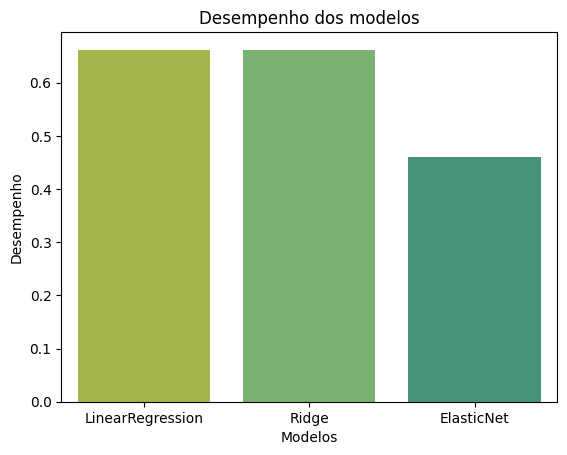

Dataframe score: 


,Modelos,R2
0,LinearRegression,0.662002
1,Ridge,0.662014
2,ElasticNet,0.460832


In [39]:
# Validação cruzada
lr_cross_val = cross_val_score(lr, x, y, cv=5, scoring='r2').mean()
ridge_cross_val = cross_val_score(ridge, x, y, cv=5, scoring='r2').mean()
net_cross_val = cross_val_score(net, x, y, cv=5, scoring='r2').mean()

cross_val_df = pd.DataFrame({
    'Modelos': [lr.__class__.__name__, ridge.__class__.__name__, net.__class__.__name__],
    'R2': [lr_cross_val, ridge_cross_val, net_cross_val]
})

sns.barplot(data=cross_val_df, x='Modelos', y='R2', palette=colors)
plt.title('Desempenho dos modelos')
plt.xlabel('Modelos')
plt.ylabel('Desempenho')
plt.show()

print('Dataframe score: ')
display(cross_val_df)

Na validação cruzada, o **Ridge Regression** se saiu rapidamente melhor que o **Linear Regression**. Menos de décimos. Porém, utilizarei Ridge, já que performou melhor.

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [41]:
# Função para treinar, testar e avaliar modelo
ridge_trained = train_test_avaliate(ridge, x_train, x_test, y_train, y_test)

MAE: 2283271.12
RMSE: 3066958.55
R2: 0.66


O modelo performou bem! Com um r2 de 67%. Agora tentarei prever os valores na base de validação, para ver se ele performa bem.

- VALIDAÇÃO

In [42]:
# Divisão dos dados de validação
x_val = df_validation_encoded.drop(columns=['Amount(in rupees)', 'Price (in rupees)'])
y_val = df_validation_encoded[['Amount(in rupees)']]

In [43]:
# função para fazer a previsão e avaliar o modelo
test_avaliate(ridge_trained, x_val, y_val)

MAE: 2848429.21
RMSE: 3883840.02
R2: 0.51


Agora o cenário muda. O modelo que desempenhou bem na base de dados de treino, não foi muito bem na base de dados de validação. Como didvidi a base de dados em treino e validação, é pouco provavel que o modelo tenha decorado, mas pode ter acontecido.

In [51]:
# Salvando modelo
joblib.dump(ridge_trained, 'ridge_model.pkl')

['ridge_model.pkl']

# Conclusão

O modelo teve um desempenho médio, com o R² de 51%, porém na base de treino de treino, ele teve um R² de 67%, mostrando que possívelmente houve overfiting, e ele não conseguiu aprender muito bem para prever os dados de validação. Para a melhoria desse modelo, é necessário fazer um melhor tratamento, talvez utilizar padronização com StandardScaler e verificar melhor a distribuição dos dados.